# xLSTM Time Series Training

In [ ]:
import sys
sys.path.insert(0, '../src')

import jax
import numpy as np
import matplotlib.pyplot as plt

from data.data_priors import (
    make_sinusoidal_generator,
    make_ar1_generator,
    make_linear_trend_generator,
    make_random_walk_generator,
    make_mixed_generator,
)
from dataset import ChunkedDataset
from xlstm_ts import xLSTMTimeSeries, ModelConfig

jax.config.update("jax_platform_name", "cpu")

## Data

In [26]:
rng = np.random.default_rng(seed=42)

# Available generators
generators = {
    "sinusoidal": make_sinusoidal_generator(noise_std=0.0, rng=rng),
    "ar1": make_ar1_generator(phi=0.9, noise_std=0.0, rng=rng),
    "ar1_noisy": make_ar1_generator(phi=0.9, noise_std=0.1, rng=rng),
    "linear": make_linear_trend_generator(noise_std=0.0, rng=rng),
    "random_walk": make_random_walk_generator(step_std=0.3, rng=rng),
}

# Choose generator
DATA_TYPE = "sinusoidal"
gen = generators[DATA_TYPE]
print(f"Data: {DATA_TYPE}")

Data: sinusoidal


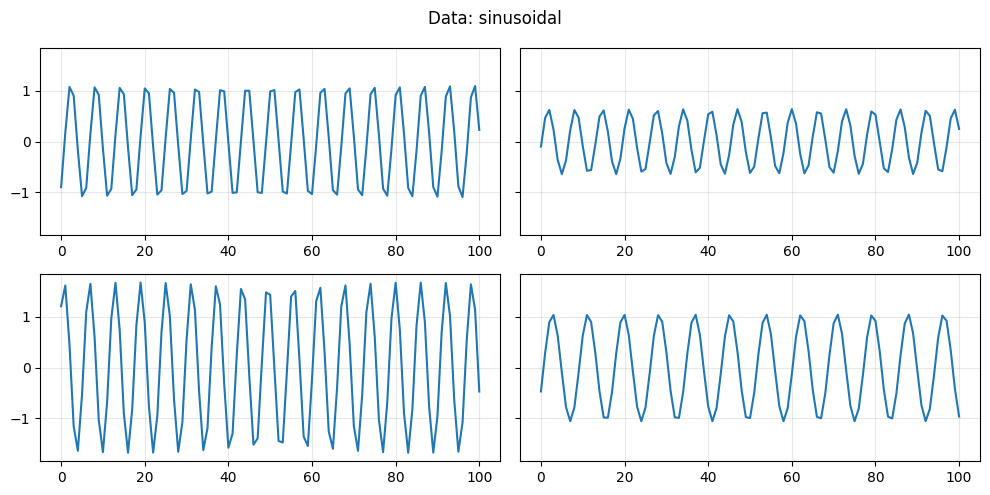

In [27]:
# Visualize
samples, _, _ = gen(n_samples=4, horizon=100)
fig, axes = plt.subplots(2, 2, figsize=(10, 5), sharey=True)
for i, ax in enumerate(axes.flat):
    ax.plot(samples[i, :, 0])
    ax.grid(True, alpha=0.3)
plt.suptitle(f"Data: {DATA_TYPE}")
plt.tight_layout()
plt.show()

## Model & Training

In [28]:
# Config
config = ModelConfig(
    input_dim=1,
    context_length=32,
    embedding_dim=16,
    num_blocks=2,
    learning_rate=1e-3,
    max_new_steps=30,
)

# Model
model = xLSTMTimeSeries(config)
print(f"Model initialized")

Model initialized


In [29]:
# Dataset & Train
dataset = ChunkedDataset(gen, n_seqs=1000, horizon=150, chunk_size=config.context_length)
losses = model.train(dataset, num_steps=500, batch_size=32, log_every=100)

Created 119000 chunks from 1000 sequences
Step    0 | Loss: 1.027854
Step  100 | Loss: 0.046648
Step  200 | Loss: 0.026744
Step  300 | Loss: 0.024339
Step  400 | Loss: 0.026522
Training complete. Final loss: 0.019640


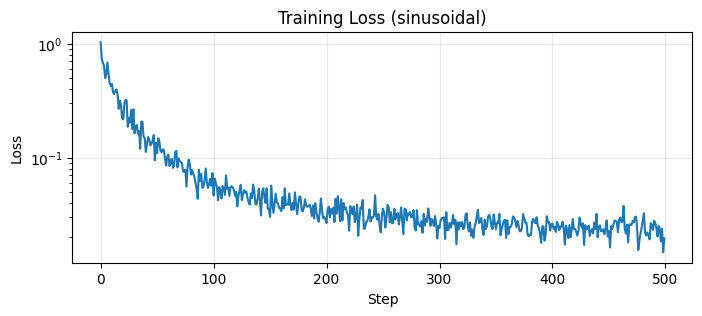

In [30]:
plt.figure(figsize=(8, 3))
plt.plot(losses)
plt.xlabel("Step"); plt.ylabel("Loss")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.title(f"Training Loss ({DATA_TYPE})")
plt.show()

## Forecasting
Using fresh test sequences from the same generator (same distribution as training).

In [31]:
# Generate test sequences (same generator = same distribution)
N_TEST = 8
N_FORECAST = config.max_new_steps
S = config.context_length

test_seqs, _, _ = gen(n_samples=N_TEST, horizon=S + N_FORECAST + 10)

# Forecast
context = test_seqs[:, :S, :1]  # (B, S, 1) - only values, not mask
forecast = model.generate(context, n_steps=N_FORECAST)

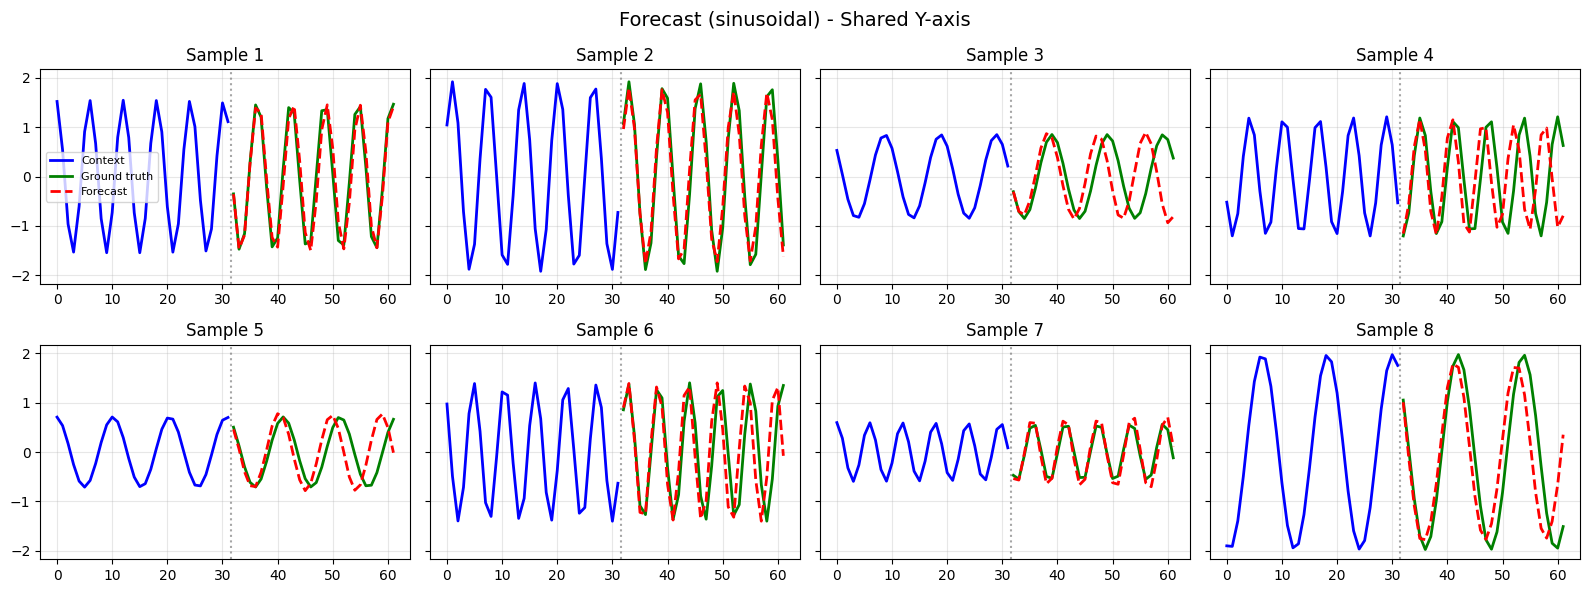

In [32]:
# Plot with shared y-axis for fair comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharey=True)

for i, ax in enumerate(axes.flat):
    t_ctx = np.arange(S)
    t_fwd = np.arange(S, S + N_FORECAST)
    
    ax.plot(t_ctx, test_seqs[i, :S, 0], 'b-', lw=2, label='Context')
    ax.plot(t_fwd, test_seqs[i, S:S+N_FORECAST, 0], 'g-', lw=2, label='Ground truth')
    ax.plot(t_fwd, forecast[i, S:S+N_FORECAST, 0], 'r--', lw=2, label='Forecast')
    ax.axvline(S - 0.5, color='gray', ls=':', alpha=0.7)
    if i == 0:
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Sample {i+1}")

plt.suptitle(f"Forecast ({DATA_TYPE}) - Shared Y-axis", fontsize=14)
plt.tight_layout()
plt.show()

## One-Step Predictions

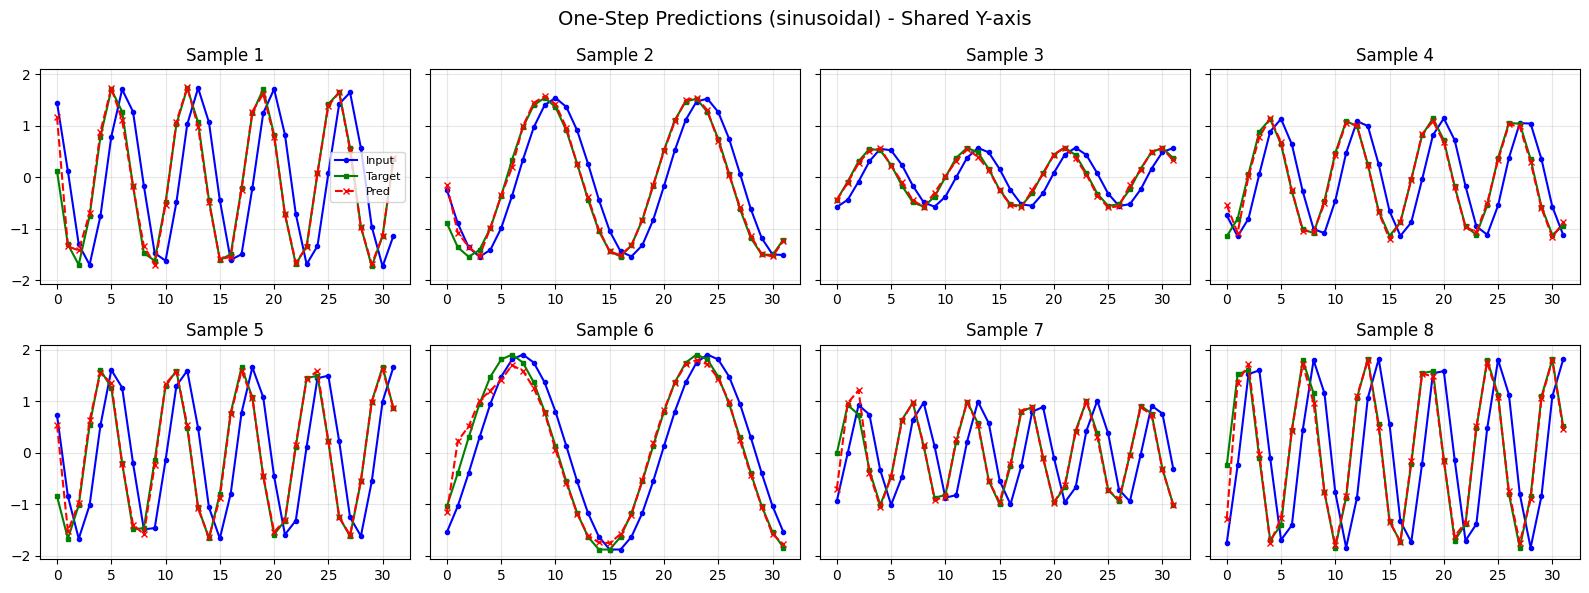

In [33]:
# Sample from training dataset for consistent scale
x_test, y_test, _ = dataset.sample_batch(8)
preds = model.predict(x_test)

fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharey=True)
for i, ax in enumerate(axes.flat):
    ax.plot(x_test[i, :, 0], 'b-', marker='o', ms=3, label='Input')
    ax.plot(y_test[i, :, 0], 'g-', marker='s', ms=3, label='Target')
    ax.plot(preds[i, :, 0], 'r--', marker='x', ms=4, label='Pred')
    if i == 0:
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_title(f"Sample {i+1}")

plt.suptitle(f"One-Step Predictions ({DATA_TYPE}) - Shared Y-axis", fontsize=14)
plt.tight_layout()
plt.show()